In [1]:
import time
import pandas as pd
# import geopandas
from math import sin, cos, sqrt, atan2, radians
from shapely.geometry import box
import ee
import folium
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

In [203]:
class irrigation30():
    
    maxSample = 100000
    # Technically, resolution can be a parameter in __init___
    #     But we did not fully test resolution different from 30 m.
    resolution = 30
    # Reference: https://hess.copernicus.org/articles/19/4441/2015/hessd-12-1329-2015.pdf
    # "If NDVI at peak is less than 0.40, the peak is not counted as cultivation." 
    #     The article uses 10-day composite NDVI while we use montly NDVI.
    #     To account for averaging effect, our threshold is slightly lower than 0.4.
    crop_ndvi_threashold = 0.3
    # Estimated based on http://www.fao.org/3/s2022e/s2022e07.htm#TopOfPage
    water_need_threshold = 100
    ndvi_lst = ['ndvi'+str(i).zfill(2) for i in range(1, 13)]
    month_lst = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    def __init__(self, center_lat=43.771114, center_lon=-116.736866, edge_len=0.005, year=2018, maxClusters_set=2):
        
        if edge_len < 0.005:
            raise ValueError('Please select an edge length greater than or equal to 0.005 degree.')
           
        # max edge_len
        # year >= 2018 (first Sentinal2 lauched around mid 2015, and the second was launched in mid 2017)
        # no 12 months of data => kill the process
        ee.Initialize()
        self.center_lat = center_lat
        self.center_lon = center_lon
        self.edge_len = edge_len
        self.year = year
        self.maxClusters_set = maxClusters_set
        self.label = []
        self.comment = ""
        self.avg_ndvi = np.zeros((2, 12))
#         self.std_ndvi = np.zeros((2, 12))
        self.image = ee.Image()
        self.nClusters = 0
        self.simple_cluster = []
            
        self.aoi_ee = self.__create_bounding_box_ee()
        self.dist_lon = self.__calc_distance(self.center_lon-self.edge_len/2, self.center_lat, self.center_lon+self.edge_len/2, self.center_lat)
        self.dist_lat = self.__calc_distance(self.center_lon, self.center_lat-self.edge_len/2, self.center_lon, self.center_lat+self.edge_len/2)
        print('The selected area is approximately {:.2f} km by {:.2f} km'.format(self.dist_lon, self.dist_lat))
        
        est_total_pixels = round(self.dist_lat*self.dist_lon*(1000**2)/((irrigation30.resolution)**2))
        self.nSample = min(irrigation30.maxSample,est_total_pixels)
#         print('The estimated percentage of pixels used in the model is {:.0%}.'.format(self.nSample/est_total_pixels))


    def __create_bounding_box_ee(self):
        return ee.Geometry.Rectangle([self.center_lon-self.edge_len/2, self.center_lat-self.edge_len/2, self.center_lon+self.edge_len/2, self.center_lat+self.edge_len/2])
    
    def __create_bounding_box_shapely(self):
        return box(self.center_lon-self.edge_len/2, self.center_lat-self.edge_len/2, self.center_lon+self.edge_len/2, self.center_lat+self.edge_len/2)

    @staticmethod
    def __calc_distance(lon1, lat1, lon2, lat2):
            # Reference: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
            # approximate radius of earth in km
            R = 6373.0
            lon1 = radians(lon1)
            lat1 = radians(lat1)
            lon2 = radians(lon2)
            lat2 = radians(lat2)
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            return distance
        
    def __pull_Sentinel2_data(self):
        band_blue = 'B2' #10m
        band_green = 'B3' #10m
        band_red = "B4"  #10m
        band_nir = 'B8'  #10m   
        
        start_date = str(self.year)+'-1-01'
        end_date = str(self.year)+'-12-31'
        
        # Create image collection that contains the area of interest
        Sentinel_IC = (ee.ImageCollection('COPERNICUS/S2')
                         .filterDate(start_date, end_date)
                         .filterBounds(self.aoi_ee)
                         .select(band_nir, band_red))
        
        # # Get GFSAD30
        GFSAD30_IC = ee.ImageCollection("users/ajsohn/GFSAD30").filterBounds(self.aoi_ee)
        GFSAD30_img = GFSAD30_IC.max().clip(self.aoi_ee)

        def __calc_NDVI(img):
            ndvi = ee.Image(img.normalizedDifference([band_nir, band_red])).rename(["ndvi"]).copyProperties(img, img.propertyNames())
            composite = img.addBands(ndvi)
            return composite
        
        def __get_by_month_data(img):
            months = ee.List.sequence(1,12)
            byMonth = ee.ImageCollection.fromImages(
                months.map(lambda m: img.filter(ee.Filter.calendarRange(m, m, 'month')).median().set('month', m)
                          ).flatten())

            # Take all the satellite bands that have been split into months 
            # as different images in collection (byMonth), and merge into different bands
            def __mergeBands(image, previous):
                return ee.Image(previous).addBands(image).copyProperties(image, image.propertyNames())

            merged = byMonth.iterate(__mergeBands, ee.Image())
            return ee.Image(merged).select(['ndvi']+['ndvi_'+str(i) for i in range(1,12)],
                irrigation30.ndvi_lst)
        
        Sentinel_IC = Sentinel_IC.map(__calc_NDVI).select('ndvi')

        # ---------- GET MONTHLY DATA ---------
        # 2 = cropland, 0 - water, 1 = non-cropland, 3 = no-data
        byMonth_img = __get_by_month_data(Sentinel_IC) \
                        .addBands(GFSAD30_img.rename(['gfsad30'])) \
                        .addBands(ee.Image("USGS/GFSAD1000_V1").rename(['gfsad1000'])) \
                        .clip(self.aoi_ee)
    
        # Mask the non-cropland
        # 0 = water, 1 = non-cropland, 2 = cropland, 3 = 'no data'
        cropland = byMonth_img.select('gfsad30').eq(2)
        byMonth_img_masked = byMonth_img.mask(cropland)
#         non_cropland = byMonth_img.select('gfsad30').lt(2) or byMonth_img.select('gfsad30').gt(2)
#         non_cropland = non_cropland.mask(non_cropland)

        return byMonth_img_masked

    def __pull_TerraClimate_data(self, band, multiplier=1):       
        start_date = str(self.year)+'-1-01'
        end_date = str(self.year)+'-12-31'
        
        # Create image collection that contains the area of interest
        TerraClimate_IC = (ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
                         .filterDate(start_date, end_date)
                         .filterBounds(self.aoi_ee)
                         .select(band))
        
        def __get_by_month_data(img):
            months = ee.List.sequence(1,12)
            byMonth = ee.ImageCollection.fromImages(
                months.map(lambda m: img.filter(ee.Filter.calendarRange(m, m, 'month')).median().set('month', m)
                          ).flatten())

            # Take all the satellite bands that have been split into months 
            # as different images in collection (byMonth), and merge into different bands
            def __mergeBands(image, previous):
                return ee.Image(previous).addBands(image).copyProperties(image, image.propertyNames())

            merged = byMonth.iterate(__mergeBands, ee.Image())
            return ee.Image(merged).select([band]+[band+'_'+str(i) for i in range(1,12)],
                [band+str(i).zfill(2) for i in range(1, 13)])

        # ---------- GET MONTHLY DATA ---------
        # 2 = cropland, 0 - water, 1 = non-cropland, 3 = no-data
        byMonth_img = __get_by_month_data(TerraClimate_IC).clip(self.aoi_ee)

        climate_dict = byMonth_img.reduceRegion(reducer=ee.Reducer.mean(), geometry=self.aoi_ee, maxPixels=1e13, scale=irrigation30.resolution).getInfo()
        climate_df = pd.DataFrame([climate_dict], columns=[band+str(i).zfill(2) for i in range(1, 13)], index=[0])
        climate_arr = climate_df.to_numpy()*multiplier
        return climate_arr
        
    def plot_precipitation(self):
        pr_arr = self.__pull_TerraClimate_data('pr')
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(irrigation30.month_lst, pr_arr[0], label='Precipitation')
        plt.legend()
        
    def plot_temperature_max_min(self):
        tmmx_arr = self.__pull_TerraClimate_data('tmmx', multiplier=0.1)
        tmmn_arr = self.__pull_TerraClimate_data('tmmn', multiplier=0.1)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(irrigation30.month_lst, tmmx_arr[0], label='Max Temperature')
        plt.plot(irrigation30.month_lst, tmmn_arr[0], label='Min Temperature')
        plt.legend()
        
    def plot_soil_moisture(self):
        # Reference: https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
        # Reference: https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/crop-water-requirement
        soil_arr = self.__pull_TerraClimate_data('soil', multiplier=0.1)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(irrigation30.month_lst, soil_arr[0], label='Soil Moisture')
        plt.legend()

    def fit_predict(self):

        self.image = self.__pull_Sentinel2_data()

#         training_FC = self.image \
#                     .select(irrigation30.ndvi_lst) \
#                     .sample(region=self.aoi_ee, scale=irrigation30.resolution, numPixels=self.nSample)
        
        training_FC = self.image.cast({'gfsad30':"int8"},['gfsad30', 'gfsad1000']+irrigation30.ndvi_lst)\
                        .stratifiedSample(region=self.aoi_ee, classBand = 'gfsad30', numPoints = self.nSample,
                        classValues = [0, 1, 3], 
                        classPoints = [0, 0, 0],
                        scale=irrigation30.resolution)\
                        .select(irrigation30.ndvi_lst)
        
        ##################################################################### stratified
        # Instantiate the clusterer and train it.
        clusterer = ee.Clusterer.wekaKMeans(self.maxClusters_set).train(training_FC, inputProperties=irrigation30.ndvi_lst)
        # wekaCascadeKMeans takes much longer to run when maxClusters is greater than minClusters
#         clusterer = ee.Clusterer.wekaCascadeKMeans(minClusters=2, maxClusters=self.maxClusters_set).train(training_FC, inputProperties=irrigation30.ndvi_lst)
#         clusterer = ee.Clusterer.wekaXMeans(minClusters=2, maxClusters=self.maxClusters_set).train(training_FC, inputProperties=irrigation30.ndvi_lst)

        # Cluster the input using the trained clusterer.
        cluster_result = self.image.cluster(clusterer)
        
        print('Model building...')
        cluster_output = dict()
        for i in range(0, self.maxClusters_set):
            cluster_output[i] = self.image.select(irrigation30.ndvi_lst).mask(cluster_result.select('cluster').eq(i)).reduceRegion(reducer=ee.Reducer.mean(), geometry=self.aoi_ee, maxPixels=1e13, scale=30).getInfo()
            if cluster_output[i]['ndvi01']==None:
                self.nClusters = i
                del cluster_output[i]
                break
            elif i == self.maxClusters_set-1:
                self.nClusters = self.maxClusters_set
        
        # Reference: https://stackoverflow.com/questions/45194934/eval-fails-in-list-comprehension
        globs = globals()
        locs = locals()
        cluster_df = pd.DataFrame([eval('cluster_output[{}]'.format(i), globs, locs) for i in range(0,self.nClusters)], columns=irrigation30.ndvi_lst, index=['Cluster_'+str(i) for i in range(0,self.nClusters)])

        self.avg_ndvi = cluster_df.to_numpy()

#         self.__identify_label_method1(cluster_result)
        self.__identify_label_method2(cluster_result)
        
        print('Model complete')
        
    def plot_map(self):
        def add_ee_layer(self, ee_object, vis_params, show, name):
            try:    
                if isinstance(ee_object, ee.image.Image):    
                    map_id_dict = ee.Image(ee_object).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles = map_id_dict['tile_fetcher'].url_format,
                        attr = 'Google Earth Engine',
                        name = name,
                        overlay = True,
                        control = True,
                        show = show
                        ).add_to(self)
                elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
                    ee_object_new = ee_object.median()
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles = map_id_dict['tile_fetcher'].url_format,
                        attr = 'Google Earth Engine',
                        name = name,
                        overlay = True,
                        control = True,
                        show = show
                        ).add_to(self)
                elif isinstance(ee_object, ee.geometry.Geometry):    
                    folium.GeoJson(
                            data = ee_object.getInfo(),
                            name = name,
                            overlay = True,
                            control = True
                        ).add_to(self)
                elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
                    ee_object_new = ee.Image().paint(ee_object, 0, 2)
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                            tiles = map_id_dict['tile_fetcher'].url_format,
                            attr = 'Google Earth Engine',
                            name = name,
                            overlay = True,
                            control = True,
                            show = show
                        ).add_to(self)

            except:
                print("Could not display {}".format(name))

        # Add EE drawing method to folium.
        folium.Map.add_ee_layer = add_ee_layer

        myMap = folium.Map(location=[self.center_lat, self.center_lon], zoom_start=8)
        aoi_shapely = self.__create_bounding_box_shapely()
        folium.GeoJson(aoi_shapely, name="Area of Interest").add_to(myMap)
        visParams = {'min':0, 'max':self.nClusters-1, 'palette': ['yellow', 'green']}
        myMap.add_ee_layer(self.image.select('prediction'), visParams, show=True, name='Prediction')
        #     0: Non-croplands (black)
        #     1: Croplands: irrigation major (green)
        #     2: Croplands: irrigation minor (lighter green)
        #     3: Croplands: rainfed (yellow)
        #     4: Croplands: rainfed, minor fragments (yellow orange)
        #     5: Croplands: rainfed, rainfed, very minor fragments (orange)
        visParams = {'min':0, 'max':5, 'palette':['black', 'green', 'a9e1a9', 'yellow', 'ffdb00', '#ffa500']}
        myMap.add_ee_layer(self.image.select('gfsad1000'), visParams, show=False, name='GFSAD1000')
        visParams = {'min':0, 'max':1, 'palette': ['red', 'yellow', 'green']}
        for i in range(1, 13):
            temp_band = 'ndvi'+str(i).zfill(2) 
            month_label = irrigation30.month_lst[i-1]
            myMap.add_ee_layer(self.image.select(temp_band), visParams, show=False, name='NDVI '+month_label)
        myMap.add_child(folium.LayerControl())
        folium.Marker([self.center_lat, self.center_lon], tooltip='center').add_to(myMap)
        print(self.comment)
        return myMap
    
    def plot_avg_ndvi(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        print(self.avg_ndvi)
        if self.nClusters == 2:
            plt.plot(irrigation30.month_lst, self.avg_ndvi[0], label=self.label[0])
            plt.plot(irrigation30.month_lst, self.avg_ndvi[1], label=self.label[1])
        else:
            for i in range(0, self.nClusters):
                plt.plot(irrigation30.month_lst, self.avg_ndvi[i], label='Cluster '+str(i))
        plt.legend()

    ##################################################################### remove
    def __smooth(self, y_raw):
        y = np.concatenate((y_raw, y_raw, y_raw))
        x = np.linspace(0, 35, num=36, endpoint=True)
        xnew = np.linspace(0, 35, num=141, endpoint=True)
        f_interp = interp1d(x, y, kind='cubic')
        y_interp = f_interp(xnew)
        y_loess = savgol_filter(y_interp, 7, 1)
        peak_index, peak_value = find_peaks(y_loess, height=0)
#         # Intermediate graph
#         plt.plot(x, y, 'o', xnew, y_loess, '--')
#         plt.plot(xnew[peak_index], peak_value['peak_heights'], "x")
#         plt.legend(['data', 'smooth'], loc='best')
#         plt.show()
        # Final graph
        final_peak_index = [i - 12 for i in xnew[peak_index] if i >= 12 and i < 24]
        print(final_peak_index)
        final_peak_value = [j for i, j in zip(xnew[peak_index], peak_value['peak_heights']) if i >= 12 and i < 24]
        final_x = [i - 12 for i in xnew if i >= 12 and i < 24]
        final_y_loess = [j for i, j in zip(xnew, y_loess) if i >= 12 and i < 24]
        return final_x, final_y_loess, final_peak_index, final_peak_value
    
    def __identify_peak(self, y_raw):
        y = np.concatenate((y_raw, y_raw, y_raw))
        x = np.linspace(0, 35, num=36, endpoint=True)
        peak_index_raw, peak_value_raw = find_peaks(y, height=irrigation30.crop_ndvi_threashold)
        # the following code handles multiple dips in a single crop season
        index_diff = np.diff(peak_index_raw)
        peak_grp = [0]
        counter = 0
        for i in index_diff:
            if i == 2:
                peak_grp.append(counter)
            else:
                counter+=1
                peak_grp.append(counter)
        peak_grp_series = pd.Series(peak_grp, name='peak_grp')
        peak_index_series = pd.Series(peak_index_raw, name='peak_index')
        peak_value_series = pd.Series(peak_value_raw['peak_heights'], name='peak_value')
        peak_grp_df = pd.concat([peak_grp_series, peak_index_series, peak_value_series], axis=1)
        peak_grp_agg_df = peak_grp_df.groupby('peak_grp').agg({'peak_index':np.mean, 'peak_value':np.max})
        peak_index = peak_grp_agg_df['peak_index'].to_numpy()
        peak_value = peak_grp_agg_df['peak_value'].to_numpy()
        
        peak_lst = [(int(i-12), irrigation30.month_lst[int(i-12)], j) for i, j in zip(peak_index, peak_value) if i >= 12 and i < 24]
        final_peak_index = [i[0] for i in peak_lst]
        final_peak_month = [i[1] for i in peak_lst]
        final_peak_value = [i[2] for i in peak_lst]
        return final_peak_index, final_peak_month, final_peak_value
    
    ##################################################################### remove
    def __identify_label_method1(self, cluster_result):
        cluster_mean = self.avg_ndvi.mean(axis=1)
        if self.nClusters == 2:
            if cluster_mean[0] < cluster_mean[1]:
                self.image = self.image.addBands(ee.Image(cluster_result.select('cluster')).rename('prediction'))
                self.label = ["Rainfed", "Irrigated"]
            else:
                self.image = self.image.addBands(ee.Image(cluster_result.expression('1-c',{'c':cluster_result.select('cluster')})).rename('prediction'))
                self.label = ["Irrigated", "Rainfed"]
        else:
            self.image = self.image.addBands(ee.Image(cluster_result.select('cluster')).rename('prediction'))
            self.label = ['Cluster_'+str(i) for i in range(0,self.nClusters)]
            
        ##################################################################### clean up prediction layer
        
#         print('Calculating standard deviation of NDVIs for Cluster 0...')
#         cluster_0_dict = self.image.select(irrigation30.ndvi_lst).mask(cluster_result.select('cluster').eq(0)).reduceRegion(reducer=ee.Reducer.stdDev(), geometry=self.aoi_ee, maxPixels=1e13, scale=irrigation30.resolution).getInfo()
#         print('Calculating standard deviation of NDVIs for Cluster 1...')
#         cluster_1_dict = self.image.select(irrigation30.ndvi_lst).mask(cluster_result.select('cluster').eq(1)).reduceRegion(reducer=ee.Reducer.stdDev(), geometry=self.aoi_ee, maxPixels=1e13, scale=irrigation30.resolution).getInfo()
#         cluster_df = pd.DataFrame([cluster_0_dict, cluster_1_dict], columns=irrigation30.ndvi_lst, index=['Cluster_0', 'Cluster_1'])
#         self.std_ndvi = cluster_df.to_numpy()


    ##################################################################### rename
    def __identify_label_method2(self, cluster_result):
        def __identify_surrounding_month(value, diff):
            new_value = value + diff
            if new_value < 0:
                new_value += 12
            elif new_value >= 12:
                new_value -= 12
            return int(new_value)
        def __calc_effective_precipitation(P):
            # Reference: 
            # Pe = 0.8 P - 25 if P > 75 mm/month
            # Pe = 0.6 P - 10 if P < 75 mm/month
            if P >= 75:
                Pe = 0.8*P-25
            else:
                Pe = max(0.6*P-10, 0)
            return Pe
        
        self.label = []
        self.comment = 'Cluster 0 -> Cluster {}: yellow -> green \n'.format(self.nClusters-1)
        for i in range(self.nClusters):
            final_peak_index, final_peak_month, final_peak_value = self.__identify_peak(self.avg_ndvi[i])
            if len(final_peak_index)==0:
                self.label.append('Cluster {}: Rainfed'.format(i))
                self.comment = self.comment + 'Cluster {}: rainfed. \n'.format(i)
            else:
                temp_label = []
                temp_comment = 'Cluster {}: {}-crop annually | '.format(i, len(final_peak_index))
                pr_arr = self.__pull_TerraClimate_data('pr')[0]
                pr_eff_arr = np.array([__calc_effective_precipitation(i) for i in pr_arr])
                pr_eff_arr = pr_arr
                for p in range(len(final_peak_index)):
                    p_index = final_peak_index[p]
                    p_lst = [__identify_surrounding_month(p_index, -1), p_index, __identify_surrounding_month(p_index, 1)]
                    pr_mean = pr_eff_arr[p_lst].mean()
                    if pr_mean >= irrigation30.water_need_threshold:
                        temp_label.append('Rainfed')
                        temp_comment = temp_comment + 'rainfed around {}; '.format(final_peak_month[p])
                    else:
                        temp_label.append('Irrigated')
                        temp_comment = temp_comment + 'irrigated around {}; '.format(final_peak_month[p])
                self.label.append('Cluster {}: '.format(i)+'+'.join(temp_label))
                self.comment = self.comment + temp_comment + '\n'
        self.image = self.image.addBands(ee.Image(cluster_result.select('cluster')).rename('prediction'))     
    
    ##################################################################### remove
    def __predict_crop_season_smooth(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        for i in range(self.nClusters):
            y_raw = self.avg_ndvi[i]
            final_x, final_y_loess, final_peak_index, final_peak_value = self.__smooth(y_raw)
            plt.plot(range(0,12), y_raw, 'o', final_x, final_y_loess, '--')
            plt.plot(final_peak_index, final_peak_value, "x")
    ##################################################################### remove    
    def predict_crop_season(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        for i in range(self.nClusters):
            y_raw = self.avg_ndvi[i]
            final_peak_index, final_peak_month, final_peak_value = self.__identify_peak(y_raw)
            plt.plot(irrigation30.month_lst, y_raw, '-')
            plt.plot(final_peak_month, final_peak_value, "x")

In [204]:
# (lon, lat)
# [82.121452, 21.706688],     // C01 (India): Doesn't look quite right.
                                              # Agree; the division feel arbitrary; both matched precipitation trend though
# [-94.46643, 48.76297],      // C02 (Canada): S2-Q1+Q4 layer is white/black. "Satellite" looks better. Irrigation is okay.
# [-105.69772, 49.316722],    // C03 (Canada): SWAP OUT WITH IDAHO.
# [10.640815, 52.185072],     // C04 (Germany): Strange S2 layers, otherwise good result. Look at flip of cropland in Q2 and Q3! Irrigation seems to coincide with Q2. 
#                                             # (one in May and the other in July) One rainfed and one irrigation or both irrigation?
# [10.7584699, 52.2058339],   // C05 (Germany): Doesn't seem right. 
# [33.857852, 46.539389],     // C06 (Ukraine): WEIRD RESULT. S2 seasonal flip-flops (Q2 and Q3 flip flop, then Q4 confusion). NDVI peaks at different seasons for each cluster. Heuristic mismatch!
#                                             # Maybe both are irrgated but at different times (April, July, and October), 3 clusters?
# [36.58565, 47.0838],        // C07 (Ukraine): Looks okay?
# [38.34523, 30.22176],       // C08 (Saudi Arabia): Looks great. Although definitely depends on season.
# [-64.075199, -31.950112],   // C09 (Argentina): NEW. Irrigation labels make no sense. Clusters have almost identical signatures.
# [67.359826, 43.55412],      // C10 (Uzbekistan): Mostly good. Although clusters seem to select areas that peak at different seasons (Q2 vs Q3). 
# [-46.2607, -11.93067]       // C11 (Brazil): Tricky case. Mostly non-cropland. 
# [-116.736866, 43.771114]    // Idaho

In [205]:
# Ukraine - Will's #6, both clsuters are irrigated. new algorithm is correct
test = irrigation30(center_lat=46.539389, center_lon=33.857852, edge_len=0.05, maxClusters_set=2)

The selected area is approximately 3.83 km by 5.56 km


In [206]:
# Ukraine - Will's #7, multiple dips are handled, new algorithm looks good.
# one irrigated, one rainfed
test = irrigation30(center_lat=47.0838, center_lon=36.58565, edge_len=0.05)

The selected area is approximately 3.79 km by 5.56 km


In [207]:
# India - compared against GFSAD30+ (GFSAD30+ marked some villedge areas as irrigated)
# test = irrigation30(center_lat=21.628880, center_lon=85.585623, edge_len=0.05)

In [208]:
# India - 2 crop (Lorenzo: Jan is irrigated for both clusters; July is rainfed + irrigation)
# test = irrigation30(center_lat=23.58014, center_lon=73.28559, edge_len=0.05)

In [209]:
# India - Adam's #2, new algorithm is consistent with old, good
# Cluster 0: 2-crop annually | irrigated around Feb; irrigated around Oct; 
# Cluster 1: 1-crop annually | irrigated around Oct; 
# test = irrigation30(center_lat=16.61968558, center_lon=77.98163937, edge_len=0.05)

In [210]:
# India - Adam's #4, new algorithm is consistent with old, but bad because the entire area should be rainfed based on gfsad30+
# one irrigated and one rainfed
# test = irrigation30(center_lat=15.36508304, center_lon=77.51866646, edge_len=0.05)

In [211]:
################################################################### gfsad30+: rainfed
# Australia - Adam's #6, multiple dip, peaks:0.66313885 and 0.52 (2018)???
# precipitation looks low for rainfed. hmmm......
test = irrigation30(center_lat=-33.83599, center_lon=138.059135, edge_len=0.05, year=2017)

The selected area is approximately 4.62 km by 5.56 km


In [212]:
################################################################### crowdsource: irrigate, gfsad30+:irrigate (circle), rain
# Australia - Adam's #10, multiple dip, peaks:0.57816652 and 0.3964???
# test = irrigation30(center_lat=-35.107376, center_lon=147.261322, edge_len=0.05, year=2019)

In [213]:
# Germary - Will's #4, (one in May and the other in July, both irrigated). new algorithm is correct
# Cluster 0: 1-crop annually | irrigated around May; 
# Cluster 1: 1-crop annually | irrigated around Jul; 
# test = irrigation30(center_lat=52.185072, center_lon=10.640815, edge_len=0.05)

In [214]:
# Argentina - Will's #9, both clusters are irrigated, the new algorithm is correct
# test = irrigation30(center_lat=-31.950112, center_lon=-64.075199, edge_len=0.05)

In [215]:
# Check precipitation resonability
# India
# https://weather-and-climate.com/average-monthly-Rainfall-Temperature-Sunshine,cochin,India
# test = irrigation30(center_lat=9.995191, center_lon=76.340577, edge_len=0.05)

In [216]:
# Vietnam with edge length of 0.1?
# left: 01, 02, 06, 12
# right: 01, 02, 05, 10
# bottom: 02, 03, 07, 12
# test = irrigation30(center_lat=10.716019771291887, center_lon=105.50046138315179, edge_len=0.05)

In [217]:
%%time
test.fit_predict()

Model building...
Model complete
CPU times: user 70 ms, sys: 0 ns, total: 70 ms
Wall time: 12.7 s


In [218]:
%%time
test.plot_map()

Cluster 0 -> Cluster 1: yellow -> green 
Cluster 0: 1-crop annually | irrigated around Sep; 
Cluster 1: 1-crop annually | irrigated around Sep; 

CPU times: user 190 ms, sys: 10 ms, total: 200 ms
Wall time: 7.75 s


[[0.02009323 0.0752986  0.06499644 0.03217597 0.10286951 0.12906479
  0.21148271 0.36227948 0.74832175 0.32148724 0.09811286 0.11140549]
 [0.01950617 0.04441557 0.05452202 0.03367013 0.16480716 0.23073372
  0.29943852 0.51226719 0.76339812 0.30830388 0.10222071 0.11106579]]


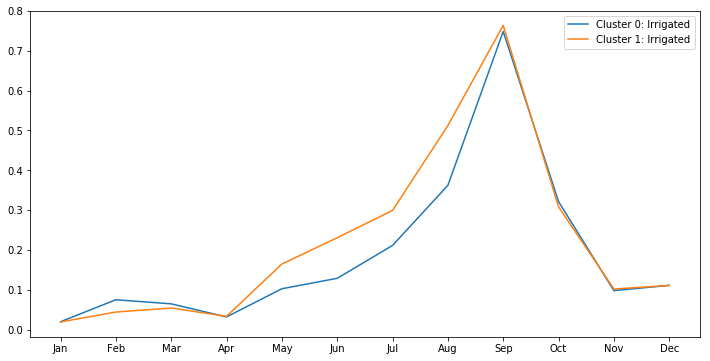

In [219]:
test.plot_avg_ndvi()

In [220]:
# test.predict_crop_season()

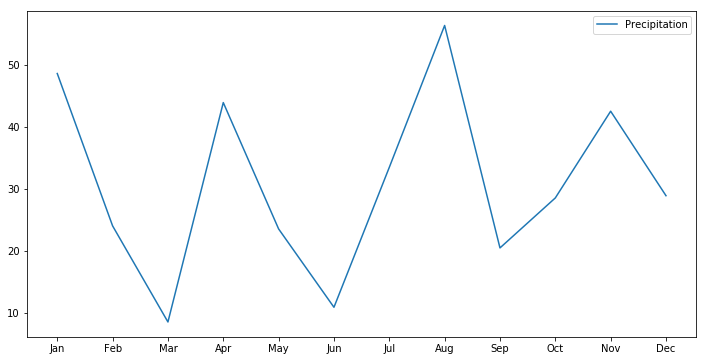

In [221]:
test.plot_precipitation()
# peak but too low? 800~600/4 = 200, at least 100mm. 5-6mm per day
# Precipitation for AUS is sometimes bad

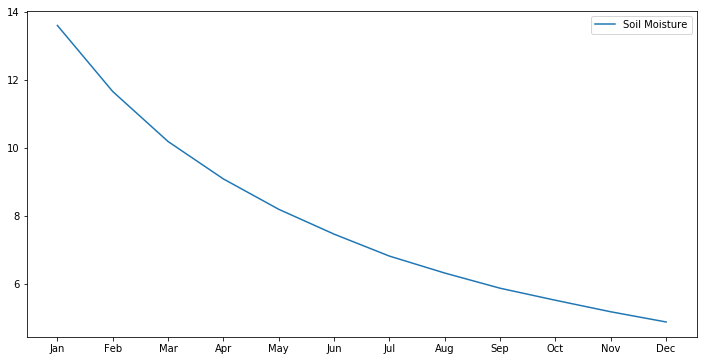

In [222]:
test.plot_soil_moisture()
# Sentinel1 has soil moisture data

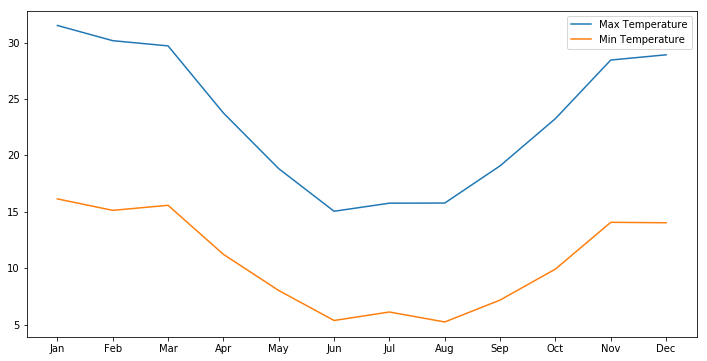

In [202]:
test.plot_temperature_max_min()
# appropriate temperature for crop? 15-35? Use Avg temperature